In [1]:
# import the necessary packages
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

pd.set_option('display.max_rows', 400)

%matplotlib inline

# Project 1

Pretend that you've been hired as a data science consultant by a public health company to do some data analyses on a [diabetes dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv). They ask you two questions:

### Question 1. Can BMI be predicted using all the other variables in the dataset? What are the relationships between our predictor variables and BMI? Which variable has the largest effect on BMI? Will this model accurately predict BMI in other similar datasets?

### Question 2. Can Diabetes (measured in the `Outcome` column, 0 indicates no diabetes, 1 indicates diabetes diagnosis) be predicted using all the other variables in the dataset? What are the relationships between our predictor variables and diabetes? Which variable has the largest effect on Diabetes diagnosis? Will this model accurately predict Diabetes in other similar datasets?

They've asked you to do some analyses and make a write up for these questions. Use code AND markdown cells to create a write up that answers the two questions above. Your write up should be something you could show you "clients" to answer their questions, like a report to present. Your write up for *each* question should include:

- a) The code for your model(s)
- b) A short explanation of why you chose each model
- c) Interpretations of the coefficents for each model<sup>1</sup>
- d) Explicit answers to each part of the Question asked by the public health company
- e) Written justifications for choices made (such as which variables to z-score, method of model validation...etc)
- f) A clear and concise interpretation of how well each of your models performed, and justification for which metrics you used to determine that
- g) Visualizations using ggplot (minimum 2 *per* question, but as many as needed) that help communicate the answers you give.

DO NOT answer any of these questions using code comments, written parts of the write up must be in markdown. Pretend that you are creating these write-ups be read by people who are NOT data scientists/statisticians, therefore try to communicate your points/justifications/answers clearly and address them to an audience who does not know a lot about data science. Get rid of superflous code, and make the reports consise, complete, and clean!

You will be graded on:
- the appropriateness of your modeling/visualization choices and their justifications,
- the clarity and effectiveness of your answers, visualizations and explanations, and
- the completeness/elegance of your analyses


<sup>1</sup>(if you use KFold or LOO, then for each predictor variable (and intercept) take the average coefficient value across all the models you made OR once you've looked at the average test set error from the cross validation, refit your model using ALL the data and grab the coefficients from that model.)

## Data Exploration

In [2]:
dfRaw = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")

validPoints = ((dfRaw['Glucose'] != 0) & 
               (dfRaw['BloodPressure'] != 0) &
               (dfRaw['Insulin'] != 0) &
               (dfRaw['BMI'] != 0))

df = dfRaw.loc[validPoints]

df.head(100)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
14,5,166,72,19,175,25.8,0.587,51,1
16,0,118,84,47,230,45.8,0.551,31,1
18,1,103,30,38,83,43.3,0.183,33,0
19,1,115,70,30,96,34.6,0.529,32,1
20,3,126,88,41,235,39.3,0.704,27,0


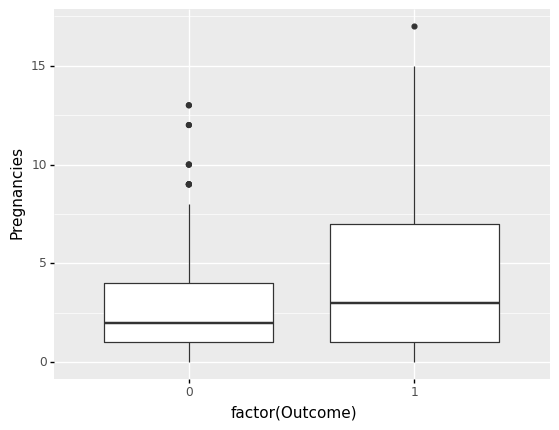

<ggplot: (113756877352)>

In [3]:
(ggplot(df, aes(x="factor(Outcome)", y="Pregnancies")) + geom_boxplot())

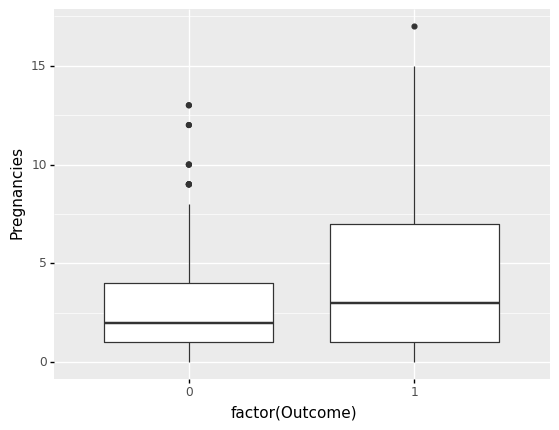

<ggplot: (113775868447)>

In [4]:
(ggplot(df, aes(x="factor(Outcome)", y="Pregnancies")) + geom_boxplot())

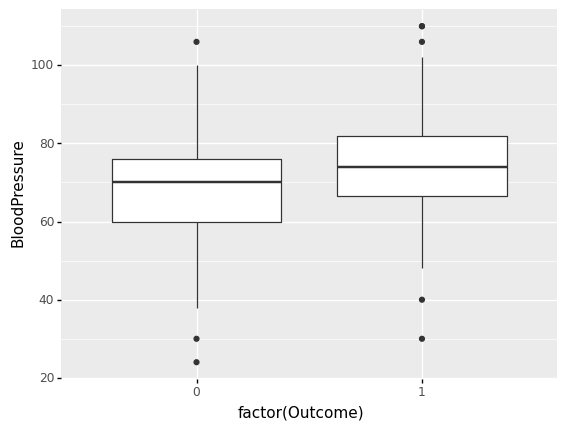

<ggplot: (113775818412)>

In [5]:
(ggplot(df, aes(x="factor(Outcome)", y="BloodPressure")) + geom_boxplot())

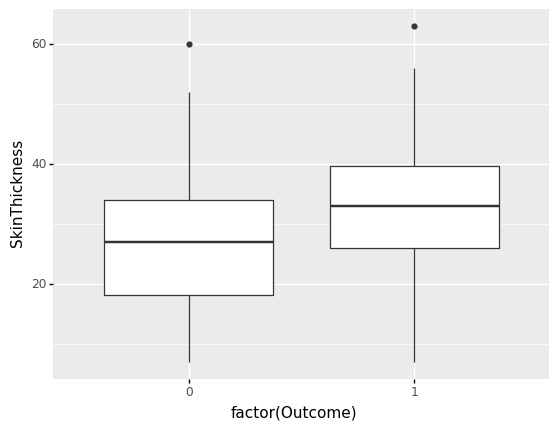

<ggplot: (113778153710)>

In [6]:
(ggplot(df, aes(x="factor(Outcome)", y="SkinThickness")) + geom_boxplot())

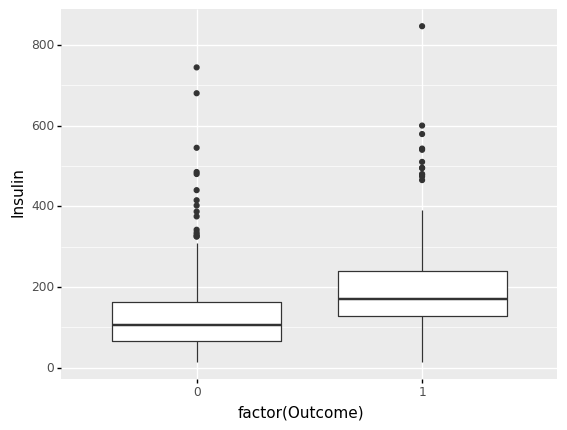

<ggplot: (113778150280)>

In [7]:
(ggplot(df, aes(x="factor(Outcome)", y="Insulin")) + geom_boxplot())

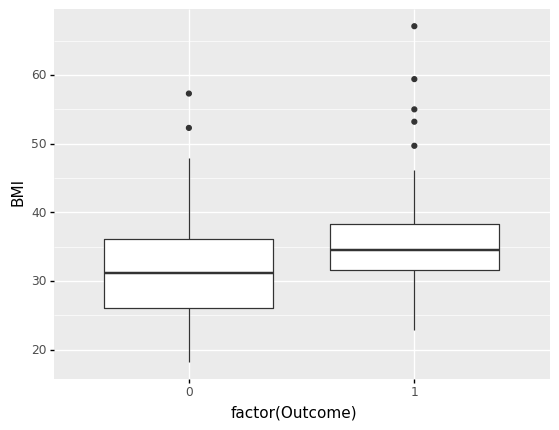

<ggplot: (113778239392)>

In [8]:
(ggplot(df, aes(x="factor(Outcome)", y="BMI")) + geom_boxplot())

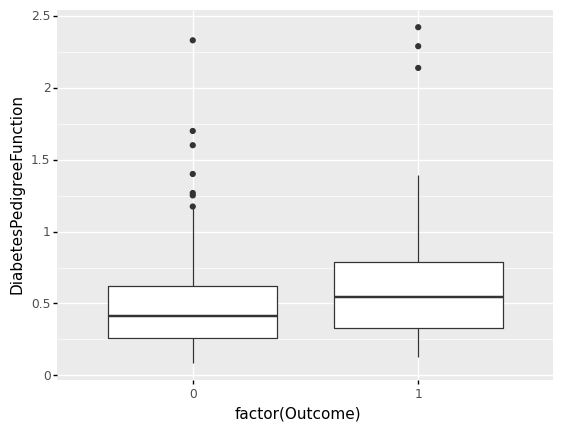

<ggplot: (113778240190)>

In [9]:
(ggplot(df, aes(x="factor(Outcome)", y="DiabetesPedigreeFunction")) + geom_boxplot())

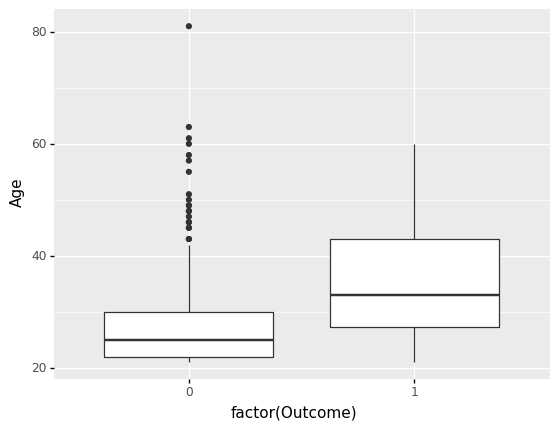

<ggplot: (113778211527)>

In [10]:
(ggplot(df, aes(x="factor(Outcome)", y="Age")) + geom_boxplot())

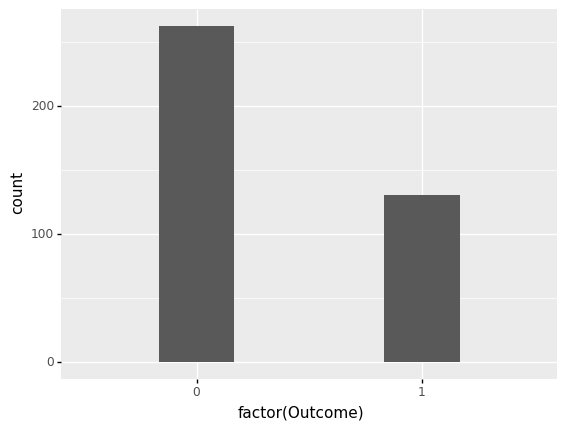

<ggplot: (113778324203)>

In [11]:
(ggplot(df, aes("factor(Outcome)")) + geom_histogram())

## Question 1

In [17]:
predBMI = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","DiabetesPedigreeFunction","Age","Outcome"]

x1 = df[predBMI]
y1 = df[["BMI"]]

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2)

z1 = StandardScaler()
z1.fit(x1_train)
x1_train = z1.transform(x1_train)
x1_test = z1.transform(x1_test)

linReg = LinearRegression()
linReg.fit(x1_train, y1_train)

LinearRegression()

In [38]:
y1_pred = linReg.predict(x1_test)

print(type(y1_test['BMI']))
print(y1_pred.shape)
# testDf = pd.DataFrame({"True" : y1_test["BMI"], "Pred" : [y1_pred]})

# (ggplot(testDf, aes(x = "True", y = "Pred")) + 
#  geom_point() +
#  geom_line(aes(x = "True", y = "True"), color="blue") +
#  labs(x = "True BMI", y = "Predicted BMI") +
#  theme_minimal())

<class 'pandas.core.series.Series'>
(79, 1)


## Question 2